In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import time
import xarray as xr

import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

import seaborn as sns


#### Import compiled_SUPERsnow.nc

In [2]:
fname = '~/Documents/projects/thesis/results/output/compiled_SUPERsnow.nc'

#ds full
ds = xr.open_dataset(fname,  chunks={'time':1,'x':1000,'y':1000})
ds.close()

#~~~~~~~~~~~~~~ds small
# dsmall = ds.sel(time='2013')
# dsmall.close()

# ds = dsmall
# ds.close()

#~~~~~~~~~~~ds peak
dpeak = ds.isel(time=[0,7,22,28,41,49])
dpeak.close()

ds = dpeak
ds.close()
ds


<xarray.Dataset>
Dimensions:  (time: 6, x: 17569, y: 17002)
Coordinates:
  * x        (x) float32 254007.0 254010.0 254013.0 ... 306708.0 306711.0
  * y        (y) float32 4230327.0 4230324.0 4230321.0 ... 4179327.0 4179324.0
  * time     (time) datetime64[ns] 2013-04-03 2014-04-07 ... 2018-04-23
    mask     (y, x) uint8 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
    dem      (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
    veg      (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
Data variables:
    snow     (time, y, x) int16 dask.array<shape=(6, 17002, 17569), chunksize=(1, 1000, 1000)>

#### Plotting features:

In [3]:
# legends/labels
d_str = pd.to_datetime(ds['time'].values).strftime("%m-%d-%Y")
print('number of legend labels:', len(d_str))


# fontsize, linewitch, etc.
fs_titles = 24
fs_labels = 24
fs_axes = 20
fs_text = 20
fs_legend = 20

number of legend labels: 6


#### test terrain layers

In [ ]:
# #brake filepath.......
# terrain_path = ''
# flist_terrain = sorted(glob.glob(terrain_path))
# flist_terrain

In [ ]:
# terrain = xr.open_dataset(flist_terrain[0]).rename({'Band1':'aspect'}) #, concat_dim='time', combine='nested', chunks={'x':1000, 'y':1000}, parallel=True)
# terrain

In [ ]:
# plt.imshow(terrain.aspect, cmap='Set2')

#### test histogram

In [ ]:
bigshape = (200000, 4000)
chunk_shape = (1000, 1000)
big_ones = da.ones(bigshape, chunks=chunk_shape)
big_ones


In [ ]:
big_calc = (big_ones * big_ones[::-1, ::-1]).mean()

with ProgressBar():
    result = big_calc.compute()
result

In [ ]:
mu = ds.snow.mean(dim=('x','y'))

with ProgressBar():
    result = mu.compute()
result


#### FUNCTIONS

In [10]:
# FUNCTION - standardize lidar by mean
def standard(x):
    a = np.where(x>0) #, x, np.nan)
    return x/np.nanmean(a)

s = xr.apply_ufunc(standard, ds.snow, dask='parallelized', output_dtypes=[np.float32])


/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


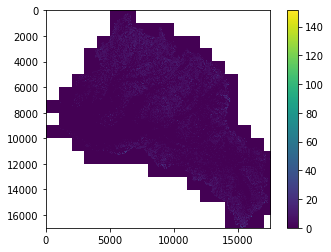

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


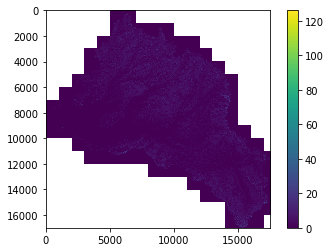

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


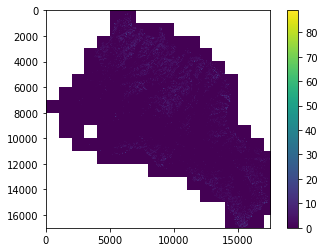

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


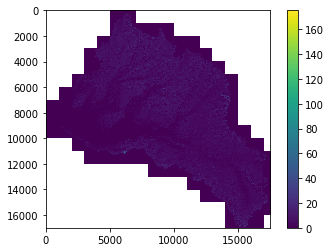

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


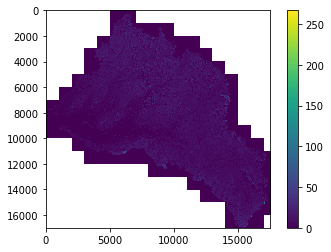

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


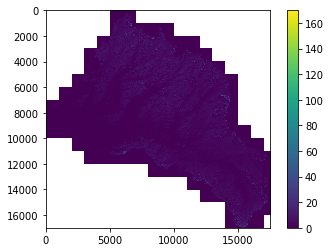

In [18]:
for i in range(s.time.size):
   
    plt.imshow(s[i])
    plt.colorbar()
    plt.show()

In [26]:
# FUNCTION - subtracts mean
def minus_mean(x):
    a = np.where(x>0) #, x, np.nan)
    return x - np.nanmean(a)


In [5]:
# FUNCTION - histogram
def histogram(x):
    '''makes histogram for all values >0 in lidar images'''
    h, bx = np.histogram(x[x !=0], bins=binx)
    return h, bx[:-1]

In [6]:
# FUNCTION - plot histogram
def step_hist_plt(hist, bin_x, date_iter, axis, alpha=0.4, lw=2, shaded=True):
    
    if shaded is True:
        a.step(bx,h, lw=lw, label = d_str[i])
        a.fill_between(bx,h, step="pre", alpha=alpha)
        
    if shaded is False:
        a.step(bx,h, lw=lw, label = d_str[i])

[####                                    ] | 10% Completed |  0.2s

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[########################################] | 100% Completed |  2.1s
[###                                     ] | 9% Completed |  0.2s

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[########################################] | 100% Completed |  2.5s
[####                                    ] | 10% Completed |  0.2s

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[########################################] | 100% Completed |  1.8s
[####                                    ] | 11% Completed |  0.2s

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[########################################] | 100% Completed |  2.1s
[###                                     ] | 7% Completed |  0.2s

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[########################################] | 100% Completed |  2.8s
[###                                     ] | 8% Completed |  0.2s

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[########################################] | 100% Completed |  2.4s


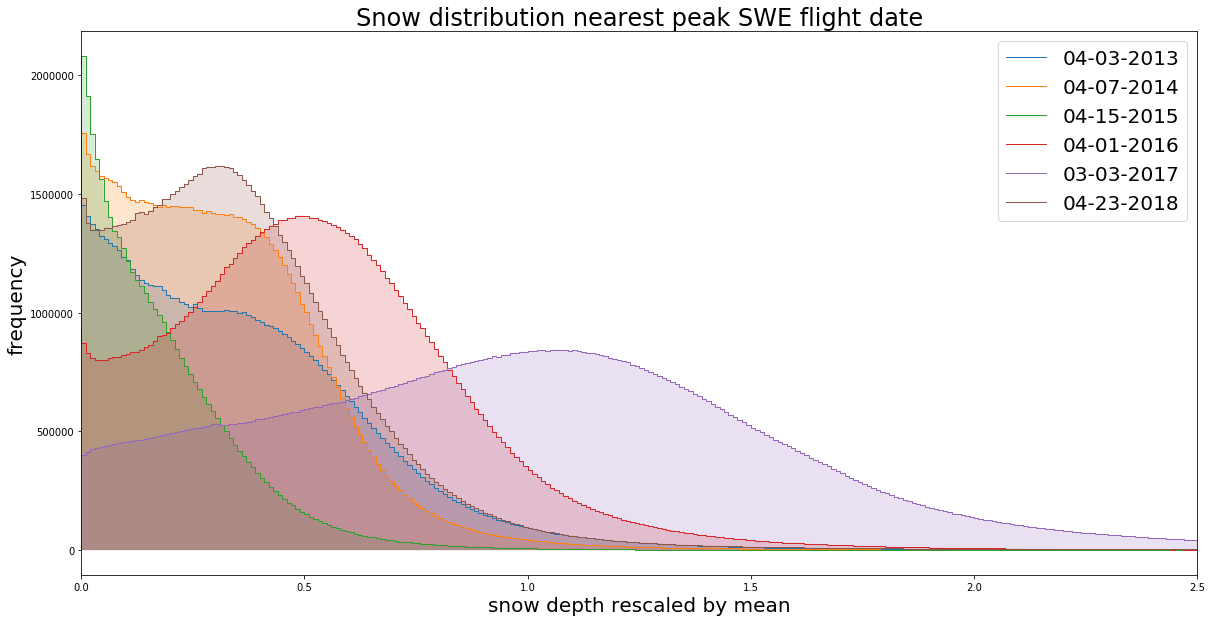

In [34]:
# binx = np.arange(0,2500,1) #(start, stop, step by [cm])
binx = np.arange(0,250,0.01)

f=plt.figure(num=0, figsize=(20,10))
a=plt.gca()

with ProgressBar(): #ATTEMPTING TO RESCALE
    for i in range(ds.time.size):
        s = xr.apply_ufunc(standard, ds.snow, dask='parallelized', output_dtypes=[np.float32])
#         mm_s = xr.apply_ufunc(minus_mean, ds.snow, dask='parallelized', output_dtypes=[np.float32])
        h, bx = xr.apply_ufunc(histogram, s[i].values/10, dask='parallelized', output_dtypes=[np.float32])
        step_hist_plt(h, bx, i, a, alpha=0.2, lw=1)

# with ProgressBar(): #SAVED FIGS FROM HERE
#     for i in range(ds.time.size):
#         h, bx = xr.apply_ufunc(histogram, ds.snow[i].values/10, dask='parallelized', output_dtypes=[np.float32])
#         step_hist_plt(h, bx, i, a, alpha=0.2, lw=5, shaded=False)
    
    a.set_title('Snow distribution nearest peak SWE flight date', fontsize=fs_titles)
    a.set_xlim(0,2.5)
    a.set_xlabel('snow depth rescaled by mean',fontsize=fs_axes)
    a.set_ylabel('frequency', fontsize=fs_axes)
    a.legend(prop={'size': fs_legend})
    plt.savefig('/home/meganmason/Documents/projects/thesis/figures/PeakDist_rescaled', dpi=600)
#     plt.show()

In [ ]:
a

In [ ]:
# bar plot (you see the rounding gaps from [m] to [mm])
fig=plt.figure(figsize=(10,5))
plt.bar(bx,h, align='edge')
plt.xlim(0,600)

In [ ]:
#fig for one!
fig=plt.figure(figsize=(10,5))
plt.step(bx,h, lw=3, label = d_str[0])
plt.fill_between(bx,h, step="pre", alpha=0.3)
plt.xlim(0,600)
plt.legend()


In [ ]:
def sns_histogram(x):
    ax = sns.distplot(x[x !=0], hist=True, bins=binx)
    return ax


In [ ]:
binx = np.arange(0,2500,2)

with ProgressBar():
    ax = xr.apply_ufunc(sns_histogram, ds.snow[0].values/10, dask='parallelized', output_dtypes=[np.int16])


In [ ]:
ds

#### one-to-one

In [ ]:
#s1~~~~~~~
s1 = ds.snow[0].values.flatten()
s1_gt_zero = s1 > 0

#s2~~~~~~
s2 = ds.snow[1].values.flatten()
s2_gt_zero = s2 > 0

In [ ]:
print(s1.shape)
print(s2.shape)

In [ ]:
s2.max()

In [ ]:
# works for 1
# plotting 1/3 of data (1,000,000)

ax = plt.scatter(s2[s1_gt_zero & s2_gt_zero][:1000000] / np.nanmean(s2[s2_gt_zero]),
            s1[s1_gt_zero & s2_gt_zero][:1000000] / np.nanmean(s1[s1_gt_zero]), alpha=0.01)


In [ ]:
#string for ONE date
# d = str(pd.to_datetime(ds['time'][0].values).date())

#pd datetime (index??) for all dates. 
d = pd.to_datetime(ds['time'].values).strftime("%m-%d-%Y")


In [ ]:
d = []
for d in range(ds.time.size):
    print(d)
#     vtimes.append(datetime.utcfromtimestamp(data.time[t].data.astype('O') / 1e9))
    d.append(ds.time[d])
print(d)

In [ ]:
ds.time.size

In [ ]:
# Create matrix with indices
index_matrix = np.zeros((5,5), dtype = int)
k_index = 1
for i_row in range(5):
    for i_column in range(5):
        index_matrix[i_row, i_column] = k_index
        k_index += 1


for i_year in range(4):
    ds.time
        

In [ ]:
# binx = np.arange(0,2500,10) #(start, stop, step by [cm])
# i=0
# with ProgressBar():   
#     h, bx = xr.apply_ufunc(histogram, ds.snow[0].values/10, dask='parallelized', output_dtypes=[np.float32])
#     step_hist_plt(h, bx, i)